## computing CO cross section using HITRAN

This tutorial demonstrates how to compute the opacity of CO using HITRAN steb by step.

In [1]:
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We use the official python package of the HITRAN interface, HAPI

https://github.com/hitranonline/hapi

In [2]:
#here we used 05_hit12.par in /home/kawahara/exojax/data/CO 
import hapi
hapi.db_begin('/home/kawahara/exojax/data/CO')

HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using /home/kawahara/exojax/data/CO

05_hit12
                     Lines parsed: 4606


In [3]:
# Setting wavenumber bins 
nus=np.linspace(1000.0,10000.0,900000,dtype=np.float64) #cm-1

In [4]:
# Loading molecular data from HITRAN
molec='05_hit12'
A = hapi.getColumn(molec, 'a')
n_air = hapi.getColumn(molec, 'n_air')
isoid = hapi.getColumn(molec,'local_iso_id')
gamma_air = hapi.getColumn(molec, 'gamma_air')
gamma_self = hapi.getColumn(molec, 'gamma_self')
nu_lines = hapi.getColumn(molec, 'nu')
delta_air = hapi.getColumn(molec, 'delta_air')
Sij0 = hapi.getColumn(molec, 'sw')
elower = hapi.getColumn(molec, 'elower')
gpp = hapi.getColumn(molec, 'gpp')

In [5]:
# exojax requires log line strengths.
logsij0=np.log(Sij0)

In [6]:
#CO isotope number
uniqiso=np.unique(isoid)

In [7]:
#molecular weight, temperature and pressure 
Mmol=28.010446441149536
Tfix=1000.0 # we assume T=1000K
bar2atm=1.0/1.01325
Pfix=1.e-3*bar2atm #we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere. 

In [8]:
# USE the HAPI partition function
Tref=296.0 # HITRAN reference temeprature is 296 K
Qr=[]
for iso in uniqiso:
    Qr.append(hapi.partitionSum(5,iso, [Tref,Tfix]))
Qr=np.array(Qr)
qr=Qr[:,0]/Qr[:,1] #Q(Tref)/Q(T)

partition function ratio qt

$q_t = Q(T_{ref})/Q(T)$; $T_{ref}$=296 K

In [9]:
# exojax also needs the partition function ratio for each line
qt=np.zeros(len(isoid))
for idx,iso in enumerate(uniqiso):
    mask=isoid==iso
    qt[mask]=qr[idx]

In [ ]:
# line strength S(T) at temperature of Tfix.
Sij=SijT(Tfix,logsij0,nu_lines,gpp,elower,qt)


$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning 

$  \gamma_L^p = \left( \frac{T}{296 \mathrm{K}} \right)^{-n_\mathrm{air}} \left[ \alpha_\mathrm{air} \left( \frac{P - P_\mathrm{self}}{1 \mathrm{atm}}\right) + \alpha_\mathrm{self} \frac{P_\mathrm{self}}{1 \mathrm{atm}} \right] $

and the natural broadening

$ \gamma_L^n = \frac{A}{4 \pi c}$

In [ ]:
# gamma factor (pressure+natural broadening)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, n_air, gamma_air, gamma_self) + gamma_natural(A) 

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [10]:
# thermal doppler sigma
sigmaD=doppler_sigma(nu_lines,Tfix,Mmol)

In [16]:
#check memory size. If the size is large for your GPU RAM, decrease d.
d=40000
numatrix=make_numatrix0(nus[0:d],nu_lines+delta_air*Pfix)
print("memory size=",numatrix.nbytes/1024/1024,"MB")

memory size= 702.81982421875 MB


In [13]:
#computing cross section
Ni=int(len(nus)/d)
xsv=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(nus[s:e],nu_lines+delta_air*Pfix)
    xsv = np.concatenate([xsv,xsvector(numatrix,sigmaD,gammaL,Sij)])

100%|██████████| 23/23 [00:03<00:00,  5.05it/s]


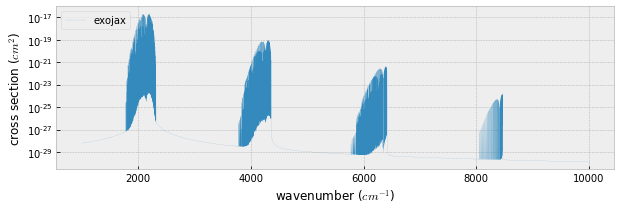

In [14]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(nus,xsv,lw=0.1,label="exojax")
plt.yscale("log")
plt.xlabel("wavenumber ($cm^{-1}$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

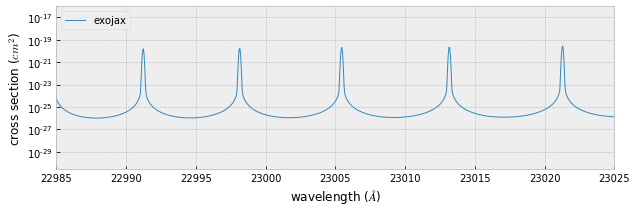

In [15]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(1.e8/nus,xsv,lw=1,label="exojax")
plt.yscale("log")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.savefig("co_hitran.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

### Note 1.

When you make numatrix, use float64 for wavenumber bin and line center.

Below, we see the difference of opacity between float64 case and float 32.

In [25]:
#computing cross section using float32 wavenumber and line center
Ni=int(len(nus)/d)
xsv_32=[]
for i in (range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(np.float32(nus[s:e]),np.float32(nu_lines+delta_air*Pfix))
    xsv_32 = np.concatenate([xsv_32,xsvector(numatrix,sigmaD,gammaL,Sij)])

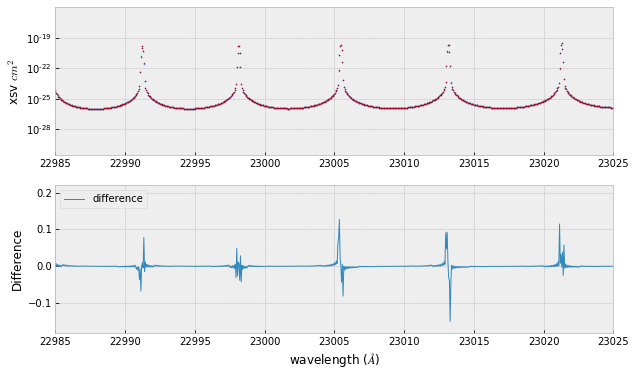

In [44]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(211)
plt.plot(1.e8/nus,xsv,".",lw=1,label="64",markersize=1)
plt.plot(1.e8/nus,xsv_32,".",lw=1,label="32",markersize=1)
plt.xlim(22985.,23025)
plt.yscale("log")
plt.ylabel("xsv $cm^{2}$")
ax=fig.add_subplot(212)
plt.plot(1.e8/nus,(xsv_32-xsv)/xsv,lw=1,label="difference")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("Difference")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.show()

We found ~ 10 % error when using float32 as an wavenumber and line center